In [1]:
# Compare SL vs SL+Projection (CIFAR-10) — Fixed Version

In [2]:
import os, glob, math, textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_GLOBS = [
    'runs/*.csv', # Logs from provided python scripts (.py)
    '*.xlsx', # Logs saved by the original .ipynb notebooks
]


COMPARE_METRIC = 'acc_test' # 'acc_test', 'acc_train', 'loss_test', 'loss_train'

# Label remapping
LABEL_MAP = {
    # 'sl_baseline_seed1234.csv': 'SL (baseline)',
    # 'sl_proj_top32_seed1234.csv': 'SL + Projection (r=32)',
}

print('Globs: ', DATA_GLOBS)


Globs:  ['runs/*.csv', '*.xlsx']


In [3]:
def load_any(path: str) -> pd.DataFrame:
    """
    Load CSV or XLSX into a normalized dataframe.
    Required columns (if pasent): round, acc_train, acc_test, loss_train, loss_train, loss_test, round_time_sec
    Adds 'source' column = basename(path).
    """
    ext = os.path.splitext(path)[1].lower()
    if ext == '.csv':
        df = pd.read_csv(path)
    elif ext in ('.xlsx', '.xls'):
        df = pd.read_excel(path)
    else:
        raise ValueError(f'Unsupported file: {path}')
    df = df.copy()
    df['source'] = os.path.basename(path)
    
    # Normalize: ensure required columns exist (fill with NaN if missing)
    for col in ['round', 'acc_train', 'acc_test', 'loss_train', 'loss_test', 'round_time_sec', 'projection', 'top_r', 'alpha', 'num_users', 'lr', 'seed']:
        if col not in df.columns:
            df[col] = np.nan
        
    # Ensure correct types when possible
    if df['round'].notna().any():
        df['round'] = df['round'].astype(int)
    return df

paths = []
for pat in DATA_GLOBS:
    paths.extend(glob.glob(pat))
    
if not paths:
    raise SystemExit('No result files found. Update DATA_GLOBS to point to the CSV/XLSX logs.')
    
dfs = [load_any(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values(['source', 'round'])
print('Loaded files:')
for p in paths:
    print(' -', os.path.basename(p))
print('\nColumns found:', list(df.columns))
df.head()
        
                

Loaded files:
 - SL ResNet18 on CIFAR-10 - Epoch 20.xlsx
 - SL ResNet18 on CIFAR-10 - with Projection.xlsx

Columns found: ['round', 'acc_train', 'acc_test', 'round_time_sec', 'source', 'loss_train', 'loss_test', 'projection', 'top_r', 'alpha', 'num_users', 'lr', 'seed', 'feature_mem_cap']


,round,acc_train,acc_test,round_time_sec,source,loss_train,loss_test,projection,top_r,alpha,num_users,lr,seed,feature_mem_cap
0,1,47.187562,24.458984,67.328051,SL ResNet18 on CIFAR-10 - Epoch 20.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,55.428013,32.861328,62.290246,SL ResNet18 on CIFAR-10 - Epoch 20.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,59.671993,38.492188,65.706682,SL ResNet18 on CIFAR-10 - Epoch 20.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,62.052318,40.550781,67.523472,SL ResNet18 on CIFAR-10 - Epoch 20.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,64.365496,41.919922,60.799040,SL ResNet18 on CIFAR-10 - Epoch 20.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saved plot:  plot_acc_test.png
Saved plot:  plot_acc_test.png
Saved plot: plot_cumulative_time.png


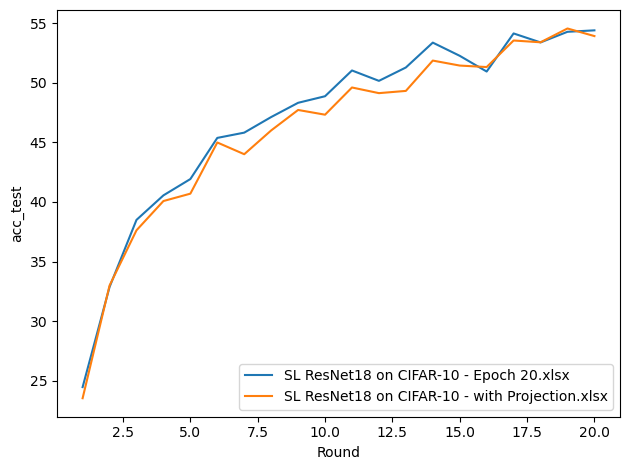

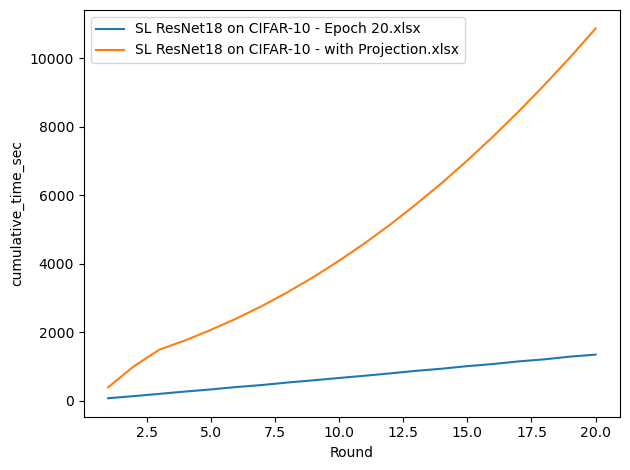

In [4]:
def pretty_label(basename: str) -> str:
    return LABEL_MAP.get(basename, basename)

def plot_metric_over_rounds(df: pd.DataFrame, metric: str, outpng: str):
    plt.figure()
    
    for src, g in df.groupby('source'):
        g = g.sort_values('round')
        if metric in g.columns and g[metric].notna().any():
            plt.plot(g['round'].values, g[metric].values, label=pretty_label(src))
        plt.xlabel('Round')
        plt.ylabel(metric)
        plt.legend()
        plt.tight_layout()
        plt.savefig(outpng, dpi=150)
        print('Saved plot: ', outpng)
        
def add_cumulative_time(df: pd.DataFrame) -> pd.DataFrame:
    # If round_time_sec exists, compute cumulative_time per source
    df = df.copy()
    if 'round_time_sec' in df.columns and df['round_time_sec'].notna().any():
        df['cumulative_time_sec'] = df.groupby('source')['round_time_sec'].cumsum()
    else:
        df['cumulative_time_sec'] = np.nan
    return df


# Prepare cumulative time
df = add_cumulative_time(df)

# Plot chosen metric over rounds
plot_metric_over_rounds(df, COMPARE_METRIC, outpng=f'plot_{COMPARE_METRIC}.png')

# Plot loss curves if available
if df['loss_test'].notna().any():
    plot_metric_over_rounds(df, 'loss_test', outpng='plot_loss_test.png')
if df['loss_train'].notna().any():
    plot_metric_over_rounds(df, 'loss_train', outpng='plot_loss_train.png')
    
    
# Plot cumulative time vs rounds if available
if df['cumulative_time_sec'].notna().any():
    plt.figure()
    for src, g in df.groupby('source'):
        g = g.sort_values('round')
        if g['cumulative_time_sec'].notna().any():
            plt.plot(g['round'].values, g['cumulative_time_sec'].values, label=pretty_label(src))
    plt.xlabel('Round')
    plt.ylabel('cumulative_time_sec')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plot_cumulative_time.png', dpi=150)
    print('Saved plot: plot_cumulative_time.png')    

In [5]:
def summarize(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    
    # Final value (last round per source)
    last = df.loc[df.groupby('source')['round'].idxmax(), ['source', metric]].rename(columns={metric: f'final_{metric}'})
    
    # Best value across rounds
    best = df.groupby('source')[metric].max().reset_index(name=f'best_{metric}')
    
    # Auc proxy: sum over rounds (higher=better for accuracy, lower = better for loss)
    auc  = df.groupby('source')[metric].sum().reset_index(name=f'sum_{metric}')

        
    # Total time if available    
    if 'cumulative_time_sec' in df.columns and df['cumulative_time_sec'].notna().any():
        tlast = df.loc[df.groupby('source')['round'].idxmax(), ['source','cumulative_time_sec']].rename(columns={'cumulative_time_sec':'total_time_sec'})
    else:
        tlast = pd.DataFrame({'source': df['source'].unique(), 'total_time_sec': np.nan})
    out = last.merge(best, on='source').merge(auc, on='source').merge(tlast, on='source')
    out = out.sort_values(f'best_{metric}', ascending=('loss' in metric))
    return out
        
        
summary = summarize(df, COMPARE_METRIC)
summary

,source,final_acc_test,best_acc_test,sum_acc_test,total_time_sec
1,SL ResNet18 on CIFAR-10 - with Projection.xlsx,53.917969,54.554688,923.011719,10868.382313
0,SL ResNet18 on CIFAR-10 - Epoch 20.xlsx,54.398438,54.398438,939.025391,1342.008018


In [6]:
# Print a simple comclusion based on chosen metric
import numpy as np

if not summary.empty:
    top = summary.iloc[0]
    winner = top['source']
    print(f'Winner by best {COMPARE_METRIC}: {winner}')
    
    if 'total_time_sec' in summary.columns and not np.isnan(top.get('total_time_sec', np.nan)):
        print(f"Total time (winner): {top['total_time_sec']:.1f} sec")
        
else:
    print('No summary could be computed.')

Winner by best acc_test: SL ResNet18 on CIFAR-10 - with Projection.xlsx
Total time (winner): 10868.4 sec
